In [40]:
# import relevant libraries
import pandas as pd
import numpy as np
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from zoneinfo import ZoneInfo
from scipy.stats import boxcox
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
# import the data scrapped from youtube into a dataframe
video_df = pd.read_csv("data/videos_unprepared.csv", parse_dates=["published_at"])
video_df.head()

,video_id,title,description,published_at,channel_title,category_id,tags,duration,definition,caption,view_count,like_count,comment_count,channel_id
0,i_wWK_n83LE,Wayne Hsiung Jailed,Original reel @DirectActionEverywhere : https:...,2023-11-05 00:21:07+00:00,SaLADS,22,[],PT34S,hd,False,2509,69,2,UCNZgGEAMXy0mweOYLHZPINw
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,It's been a couple of years since I last spoke...,2022-04-08 20:56:09+00:00,Clif Grant,22,[],PT57M33S,hd,False,1556,237,75,UChD3chubIKyNo0Z2TppQ-Fw
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,17 March 1990 – ALF liberates more than 100 an...,2021-10-07 18:41:22+00:00,Alex Punx,29,"['animal liberation front', 'frente de liberac...",PT51S,sd,False,1712,85,5,UCi919GSAtsLqFHjMnuWVm9Q
3,tKUv8JrrzSY,Vegan Kills More Animals 🤯| Ted Nugent,Ted Nugent Explains How Vegan Kills More Anima...,2023-01-31 12:30:32+00:00,Business Bulls,22,"['Business', 'success', 'investing', 'finance'...",PT46S,hd,False,108193,5506,742,UC-YvsfPu6tlCAd8AQUyoWRg
4,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,A quick street conversation with a non-vegan m...,2020-11-16 19:00:08+00:00,Edmonton Vegan Outreach,29,"['Cube of Truth', 'Anonymous for the Voiceless...",PT2M21S,hd,False,378,44,1,UCsU5QtzfvVX2DFcmIYM3aRg


In [42]:
# check dataframe info
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   video_id       978 non-null    object             
 1   title          978 non-null    object             
 2   description    883 non-null    object             
 3   published_at   978 non-null    datetime64[ns, UTC]
 4   channel_title  978 non-null    object             
 5   category_id    978 non-null    int64              
 6   tags           978 non-null    object             
 7   duration       978 non-null    object             
 8   definition     978 non-null    object             
 9   caption        978 non-null    bool               
 10  view_count     978 non-null    int64              
 11  like_count     978 non-null    int64              
 12  comment_count  978 non-null    int64              
 13  channel_id     978 non-null    object             

In [43]:
# fill blank descriptions with empty strings
video_df["description"] = video_df["description"].fillna("")

In [44]:
# Add hour, weekday and month published columns as well as how many days the video has been published for
video_df["hour_published"] = video_df["published_at"].dt.hour
video_df["weekday_published"] = video_df["published_at"].dt.weekday
video_df["month_published"] = video_df["published_at"].dt.month
scrape_date = datetime(2025, 6, 30, tzinfo=ZoneInfo("Europe/London"))
video_df["published_duration_days"] = (scrape_date - video_df["published_at"]).dt.days
video_df.drop(columns="published_at", inplace=True)
video_df.head()

,video_id,title,description,channel_title,category_id,tags,duration,definition,caption,view_count,like_count,comment_count,channel_id,hour_published,weekday_published,month_published,published_duration_days
0,i_wWK_n83LE,Wayne Hsiung Jailed,Original reel @DirectActionEverywhere : https:...,SaLADS,22,[],PT34S,hd,False,2509,69,2,UCNZgGEAMXy0mweOYLHZPINw,0,6,11,602
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,It's been a couple of years since I last spoke...,Clif Grant,22,[],PT57M33S,hd,False,1556,237,75,UChD3chubIKyNo0Z2TppQ-Fw,20,4,4,1178
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,17 March 1990 – ALF liberates more than 100 an...,Alex Punx,29,"['animal liberation front', 'frente de liberac...",PT51S,sd,False,1712,85,5,UCi919GSAtsLqFHjMnuWVm9Q,18,3,10,1361
3,tKUv8JrrzSY,Vegan Kills More Animals 🤯| Ted Nugent,Ted Nugent Explains How Vegan Kills More Anima...,Business Bulls,22,"['Business', 'success', 'investing', 'finance'...",PT46S,hd,False,108193,5506,742,UC-YvsfPu6tlCAd8AQUyoWRg,12,1,1,880
4,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,A quick street conversation with a non-vegan m...,Edmonton Vegan Outreach,29,"['Cube of Truth', 'Anonymous for the Voiceless...",PT2M21S,hd,False,378,44,1,UCsU5QtzfvVX2DFcmIYM3aRg,19,0,11,1686


In [45]:
# import the category & channel data and merge it to the video dataframe
categories = pd.read_csv("data/categories.csv")
channels = pd.read_csv("data/channels.csv")
video_df = video_df.merge(categories, on="category_id").merge(channels, on="channel_id").drop(columns=["category_id", "channel_id"])
video_df.head()

,video_id,title,description,channel_title,tags,duration,definition,caption,view_count,like_count,comment_count,hour_published,weekday_published,month_published,published_duration_days,category,channel_name,channel_view_count,channel_sub_count,channel_video_count
0,i_wWK_n83LE,Wayne Hsiung Jailed,Original reel @DirectActionEverywhere : https:...,SaLADS,[],PT34S,hd,False,2509,69,2,0,6,11,602,People & Blogs,SaLADS,151430,1610,314
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,It's been a couple of years since I last spoke...,Clif Grant,[],PT57M33S,hd,False,1556,237,75,20,4,4,1178,People & Blogs,Clif Grant,381041,4300,218
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,17 March 1990 – ALF liberates more than 100 an...,Alex Punx,"['animal liberation front', 'frente de liberac...",PT51S,sd,False,1712,85,5,18,3,10,1361,Nonprofits & Activism,Alex Punx,2885119,6420,846
3,tKUv8JrrzSY,Vegan Kills More Animals 🤯| Ted Nugent,Ted Nugent Explains How Vegan Kills More Anima...,Business Bulls,"['Business', 'success', 'investing', 'finance'...",PT46S,hd,False,108193,5506,742,12,1,1,880,People & Blogs,Business Bulls,98794447,169000,622
4,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,A quick street conversation with a non-vegan m...,Edmonton Vegan Outreach,"['Cube of Truth', 'Anonymous for the Voiceless...",PT2M21S,hd,False,378,44,1,19,0,11,1686,Nonprofits & Activism,Edmonton Vegan Outreach,53670,885,129


In [46]:
# check value counts for different video categories
category_counts = video_df["category"].value_counts()
category_counts

category
Nonprofits & Activism    294
People & Blogs           194
Entertainment            168
Education                 84
Science & Technology      73
News & Politics           48
Pets & Animals            33
Howto & Style             31
Comedy                    17
Music                     13
Film & Animation           7
Sports                     6
Travel & Events            6
Gaming                     3
Autos & Vehicles           1
Name: count, dtype: int64

In [47]:
# combine value counts less than 10 into "Other" category
rare_categories = category_counts[category_counts < 10].index
video_df["category"] = video_df["category"].replace(rare_categories, "Other")
category_counts = video_df["category"].value_counts()
category_counts

category
Nonprofits & Activism    294
People & Blogs           194
Entertainment            168
Education                 84
Science & Technology      73
News & Politics           48
Pets & Animals            33
Howto & Style             31
Other                     23
Comedy                    17
Music                     13
Name: count, dtype: int64

In [48]:
# convert duration into total seconds and add binary feature for Youtube shorts
hours = video_df["duration"].str.extract(r"PT(\d+)H")[0].fillna(0).astype(int)
minutes = video_df["duration"].str.extract(r"(\d+)M")[0].fillna(0).astype(int)
seconds = video_df["duration"].str.extract(r"(\d+)S")[0].fillna(0).astype(int)
duration = pd.to_timedelta(hours, unit="hours") + pd.to_timedelta(minutes, unit="minutes") + pd.to_timedelta(seconds, unit="seconds")
video_df["duration_seconds"] = duration.dt.total_seconds().astype(int)
video_df.drop(columns="duration", inplace=True)
video_df["is_short"] = np.where(video_df["duration_seconds"] <= 180, 1, 0)
video_df.head()

,video_id,title,description,channel_title,tags,definition,caption,view_count,like_count,comment_count,...,weekday_published,month_published,published_duration_days,category,channel_name,channel_view_count,channel_sub_count,channel_video_count,duration_seconds,is_short
0,i_wWK_n83LE,Wayne Hsiung Jailed,Original reel @DirectActionEverywhere : https:...,SaLADS,[],hd,False,2509,69,2,...,6,11,602,People & Blogs,SaLADS,151430,1610,314,34,1
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,It's been a couple of years since I last spoke...,Clif Grant,[],hd,False,1556,237,75,...,4,4,1178,People & Blogs,Clif Grant,381041,4300,218,3453,0
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,17 March 1990 – ALF liberates more than 100 an...,Alex Punx,"['animal liberation front', 'frente de liberac...",sd,False,1712,85,5,...,3,10,1361,Nonprofits & Activism,Alex Punx,2885119,6420,846,51,1
3,tKUv8JrrzSY,Vegan Kills More Animals 🤯| Ted Nugent,Ted Nugent Explains How Vegan Kills More Anima...,Business Bulls,"['Business', 'success', 'investing', 'finance'...",hd,False,108193,5506,742,...,1,1,880,People & Blogs,Business Bulls,98794447,169000,622,46,1
4,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,A quick street conversation with a non-vegan m...,Edmonton Vegan Outreach,"['Cube of Truth', 'Anonymous for the Voiceless...",hd,False,378,44,1,...,0,11,1686,Nonprofits & Activism,Edmonton Vegan Outreach,53670,885,129,141,1


In [49]:
# update definition and caption to binary variables (0 = sd, 1 = hd & 0 = False, 1 = True)
video_df["hd"] = np.where(video_df["definition"] == "hd", 1, 0)
video_df["caption"] = np.where(video_df["caption"] == True, 1, 0)
video_df.drop(columns="definition", inplace=True)
video_df.head()

,video_id,title,description,channel_title,tags,caption,view_count,like_count,comment_count,hour_published,...,month_published,published_duration_days,category,channel_name,channel_view_count,channel_sub_count,channel_video_count,duration_seconds,is_short,hd
0,i_wWK_n83LE,Wayne Hsiung Jailed,Original reel @DirectActionEverywhere : https:...,SaLADS,[],0,2509,69,2,0,...,11,602,People & Blogs,SaLADS,151430,1610,314,34,1,1
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,It's been a couple of years since I last spoke...,Clif Grant,[],0,1556,237,75,20,...,4,1178,People & Blogs,Clif Grant,381041,4300,218,3453,0,1
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,17 March 1990 – ALF liberates more than 100 an...,Alex Punx,"['animal liberation front', 'frente de liberac...",0,1712,85,5,18,...,10,1361,Nonprofits & Activism,Alex Punx,2885119,6420,846,51,1,0
3,tKUv8JrrzSY,Vegan Kills More Animals 🤯| Ted Nugent,Ted Nugent Explains How Vegan Kills More Anima...,Business Bulls,"['Business', 'success', 'investing', 'finance'...",0,108193,5506,742,12,...,1,880,People & Blogs,Business Bulls,98794447,169000,622,46,1,1
4,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,A quick street conversation with a non-vegan m...,Edmonton Vegan Outreach,"['Cube of Truth', 'Anonymous for the Voiceless...",0,378,44,1,19,...,11,1686,Nonprofits & Activism,Edmonton Vegan Outreach,53670,885,129,141,1,1


In [50]:
# check unique channel names
video_df["channel_name"].unique()

array(['SaLADS', 'Clif Grant', 'Alex Punx', 'Business Bulls',
       'Edmonton Vegan Outreach', 'Earthling Ed', 'VLNOW', 'David Ramms',
       'Mic the Vegan', 'Vegan Pixie Warrior', 'earthlingsthemovie',
       'Gillian Berry', 'Rich Roll', 'Joey Carbstrong', 'Stichting NoFap',
       'Vegan Outreach', 'Thee Burger Dude', 'KRQE', 'Seb Alex',
       'Lex Clips', 'Dr Sermed Mezher', 'PureCarbs', 'TEDx Talks',
       'Those Annoying Vegans', 'Renaissance Periodization',
       'PLANT BASED NEWS', 'Matt Ross', 'Arvind Animal Activist', 'VFC',
       'The Ethical Compass', 'FullyRawKristina', 'sixteenleo',
       'Vegan Gains', 'Rocco’s Videos', 'Plant Strength',
       'Vegan Gains Clips', 'Entyce The Lyrical Vegan', 'Peter Rogers MD',
       'KenDBerryMD', 'Good Morning Britain', 'Being Enlightened',
       'Last Chance for Animals', 'sethpajak', 'voicetheunheard',
       'Last Night On Destiny', "Men's Health",
       'Veganism EXPOSED Official ', 'Brut India',
       'Direct Action Eve

In [51]:
# filter out unwanted channels
remove_channels = ["Business Bulls", "VLNOW", "Stichting NoFap", "KRQE", "Dr Sermed Mezher", "Renaissance Periodization", "sixteenleo", "KenDBerryMD", "Good Morning Britain", "Men's Health", "Veganism EXPOSED Official ", "Type One Talks", "TheSeriousfitness", "TransformXRED - Delray Misfits Museum",
                   "BBC Global", "Fly & Shy", "Greg Doucette", "Vegan Deterioration", "Physicians Committee", "WPTV News - FL Palm Beaches and Treasure Coast", "HustleTalk", "GradeAUnderA", "Addis Miller", "Lolcows of the Internet", "The Funny Republican", "Goodmorning1221",
                   "Big Craig", "news.com.au", "Bonnelli Factory DGG", "DawahWise", "The Young Turks", "Meditate Like a Jedi with Lama Jigme Gyatso", "Shannen Michaela ", "Highvan" "Muscle & Strength", "BBC World Service", "Health Coach Joff", "BS w/ Jake Paul", "LMAOF", "ITV Gold",
                   "Projector Jenna Ortega", "The Iced Coffee Hour", "3ooQ", "Fitxfearless Clips", "Doctor Mike", "Bobby's Perspective", "TinkABoutDis", "Piers Morgan Uncensored", "Internet Anarchist", "AsapSCIENCE", "Garland Farms", "Vince Goodrum", "Isaac Butterfield", "FITXFEARLESS",
                   "Learn with Jaspal", "Vaibhav Shukla", "Alec Gunter", "Philosophy Sam", "VICE", "Insider Tech", "KPIX | CBS NEWS BAY AREA", "WIRED", "Rina", "Habitat Botanicals", "GBNews", "odoublegg", "Caleb Maupin", "Playing With Fire", "Frank Tufano", "Rachael Ray Show", "MehtaEthics",
                   "The Flip Flop Report", "Warrior Mentality", "Dr. Bobby Price", "Next Level Stuff", "Goatis", "ASH Loves Condiments", "SenyaiGrubs", "Simply Just Cee!", "Dave Feldman"]

video_df_filtered = video_df[~video_df["channel_name"].isin(remove_channels)]
video_df_filtered.shape

(874, 21)

In [52]:
# filter out videos less than 7 days old
video_df_filtered = video_df_filtered[video_df_filtered["published_duration_days"] >= 7]
video_df_filtered.shape

(866, 21)

In [55]:
# filter out unwanted video subjects
unwanted_keywords = ["russia", "ukraine", "israel", "palestine", "gaza", "trump", "trump's", "biden", "biden's", "abortion"]

def is_unwanted(text):
    text = str(text).lower()
    return any(keyword in text for keyword in unwanted_keywords)

video_df_filtered = video_df_filtered[~video_df_filtered["title"].apply(is_unwanted)]
video_df_filtered = video_df_filtered[~video_df_filtered["description"].apply(is_unwanted)]
video_df_filtered.shape

(846, 21)

In [56]:
# calculate view rate target variable
video_df_filtered["view_rate"] = video_df_filtered["view_count"] / video_df_filtered["published_duration_days"]
video_df_filtered.head()

,video_id,title,description,channel_title,tags,caption,view_count,like_count,comment_count,hour_published,...,published_duration_days,category,channel_name,channel_view_count,channel_sub_count,channel_video_count,duration_seconds,is_short,hd,view_rate
0,i_wWK_n83LE,Wayne Hsiung Jailed,Original reel @DirectActionEverywhere : https:...,SaLADS,[],0,2509,69,2,0,...,602,People & Blogs,SaLADS,151430,1610,314,34,1,1,4.167774
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,It's been a couple of years since I last spoke...,Clif Grant,[],0,1556,237,75,20,...,1178,People & Blogs,Clif Grant,381041,4300,218,3453,0,1,1.320883
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,17 March 1990 – ALF liberates more than 100 an...,Alex Punx,"['animal liberation front', 'frente de liberac...",0,1712,85,5,18,...,1361,Nonprofits & Activism,Alex Punx,2885119,6420,846,51,1,0,1.257899
4,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,A quick street conversation with a non-vegan m...,Edmonton Vegan Outreach,"['Cube of Truth', 'Anonymous for the Voiceless...",0,378,44,1,19,...,1686,Nonprofits & Activism,Edmonton Vegan Outreach,53670,885,129,141,1,1,0.224199
5,OHi9VF_0CFM,Difficulties with Non-Vegan Friends & Family (...,Advice with dealing with non-vegan friends and...,Earthling Ed,"['earthlinged', 'earthling ed', 'vegan', 'vega...",1,204645,16510,2351,20,...,2818,Nonprofits & Activism,Earthling Ed,60458765,456000,379,794,0,1,72.620653


In [57]:
# split up tags to get a value count
video_df_filtered["tags"] = video_df_filtered["tags"].apply(lambda x: ast.literal_eval(x))
all_tags = video_df_filtered["tags"].explode().str.lower()
tag_counts = all_tags.value_counts()
tag_counts

tags
vegan                                            354
veganism                                         216
animal rights                                    139
earthling ed                                      93
activism                                          82
                                                ... 
what i wish i knew before going vegan              1
before you go vegan                                1
how to start a plant based diet for beginners      1
plant based diet before and after                  1
whole food plant based weight loss                 1
Name: count, Length: 4780, dtype: int64

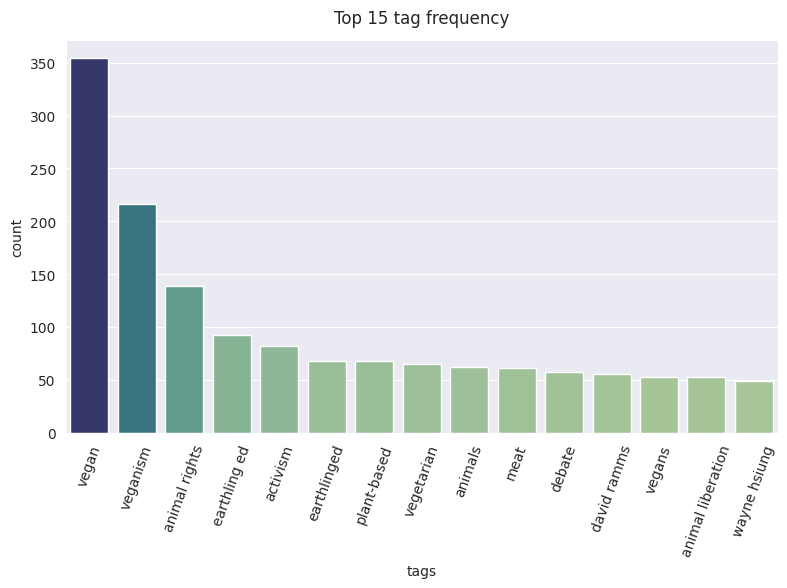

In [59]:
# visualize tag frequency
sns.set_style("darkgrid")
plt.subplots(figsize=(8, 6))
sns.barplot(x=tag_counts.index[:15], y=tag_counts.values[:15], palette="crest", hue=tag_counts[:15], legend=False)
plt.title("Top 15 tag frequency", y=1.02)
plt.ylabel("count")
plt.xticks(rotation=70)
plt.tight_layout()

# save png
plt.savefig("images/tag_frequency.png", dpi=300)

In [60]:
# create a binary column for each of the most popular tags and also a total tag count
popular_tags = ["vegan", "veganism", "animal rights", r"earthling ed|earthlinged", "activism", "animals", "plant-based", "meat", "vegetarian", "animal liberation", "debate"]

for pop_tag in popular_tags:
    video_df_filtered[f"tag_{pop_tag}"] = video_df_filtered["tags"].apply(
        lambda video_tags: int(any(re.search(pop_tag, video_tag) for video_tag in video_tags))
    )

video_df_filtered["tag_count"] = video_df_filtered["tags"].apply(lambda tags: len(tags))
video_df_filtered.drop(columns="tags", inplace=True)
video_df_filtered.head()

,video_id,title,description,channel_title,caption,view_count,like_count,comment_count,hour_published,weekday_published,...,tag_animal rights,tag_earthling ed|earthlinged,tag_activism,tag_animals,tag_plant-based,tag_meat,tag_vegetarian,tag_animal liberation,tag_debate,tag_count
0,i_wWK_n83LE,Wayne Hsiung Jailed,Original reel @DirectActionEverywhere : https:...,SaLADS,0,2509,69,2,0,6,...,0,0,0,0,0,0,0,0,0,0
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,It's been a couple of years since I last spoke...,Clif Grant,0,1556,237,75,20,4,...,0,0,0,0,0,0,0,0,0,0
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,17 March 1990 – ALF liberates more than 100 an...,Alex Punx,0,1712,85,5,18,3,...,0,0,0,0,0,0,0,1,0,8
4,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,A quick street conversation with a non-vegan m...,Edmonton Vegan Outreach,0,378,44,1,19,0,...,0,0,1,0,0,1,1,0,1,36
5,OHi9VF_0CFM,Difficulties with Non-Vegan Friends & Family (...,Advice with dealing with non-vegan friends and...,Earthling Ed,1,204645,16510,2351,20,2,...,0,1,1,0,0,0,1,0,0,25


In [61]:
# add title and description length
video_df_filtered["title_length"] = video_df_filtered["title"].apply(lambda title: len(title))
video_df_filtered["description_length"] = video_df_filtered["description"].apply(lambda description: len(str(description)))

# vectorize the term frequency of title and description
video_df_filtered["text"] = video_df_filtered["title"] + " " + video_df_filtered["description"].fillna("")

vectorizer = TfidfVectorizer(max_features=300, stop_words="english", min_df=3)
tf_idf_matrix = vectorizer.fit_transform(video_df_filtered["text"])

tf_idf_df = pd.DataFrame(tf_idf_matrix.toarray(), columns=[f"term_{term}" for term in vectorizer.get_feature_names_out()])
video_df_filtered = pd.concat([video_df_filtered.reset_index(drop=True), tf_idf_df.reset_index(drop=True)], axis=1)
video_df_filtered.head()

,video_id,title,description,channel_title,caption,view_count,like_count,comment_count,hour_published,weekday_published,...,term_wayne,term_website,term_winters,term_work,term_world,term_www,term_year,term_years,term_youtu,term_youtube
0,i_wWK_n83LE,Wayne Hsiung Jailed,Original reel @DirectActionEverywhere : https:...,SaLADS,0,2509,69,2,0,6,...,0.248285,0.0,0.0,0.000000,0.000000,0.353566,0.0,0.00000,0.0,0.244901
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,It's been a couple of years since I last spoke...,Clif Grant,0,1556,237,75,20,4,...,0.000000,0.0,0.0,0.000000,0.101021,0.092007,0.0,0.24063,0.0,0.063730
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,17 March 1990 – ALF liberates more than 100 an...,Alex Punx,0,1712,85,5,18,3,...,0.000000,0.0,0.0,0.000000,0.000000,0.066827,0.0,0.00000,0.0,0.000000
3,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,A quick street conversation with a non-vegan m...,Edmonton Vegan Outreach,0,378,44,1,19,0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000
4,OHi9VF_0CFM,Difficulties with Non-Vegan Friends & Family (...,Advice with dealing with non-vegan friends and...,Earthling Ed,1,204645,16510,2351,20,2,...,0.000000,0.0,0.0,0.160942,0.000000,0.000000,0.0,0.00000,0.0,0.000000


In [62]:
# drop no longer needed columns (including like_count and comment_count to avoid data leakage)
remove_columns = ["view_count", "description", "text", "like_count", "comment_count"]
video_df_filtered.drop(columns=remove_columns, inplace=True)
video_df_filtered.head()

,video_id,title,channel_title,caption,hour_published,weekday_published,month_published,published_duration_days,category,channel_name,...,term_wayne,term_website,term_winters,term_work,term_world,term_www,term_year,term_years,term_youtu,term_youtube
0,i_wWK_n83LE,Wayne Hsiung Jailed,SaLADS,0,0,6,11,602,People & Blogs,SaLADS,...,0.248285,0.0,0.0,0.000000,0.000000,0.353566,0.0,0.00000,0.0,0.244901
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,Clif Grant,0,20,4,4,1178,People & Blogs,Clif Grant,...,0.000000,0.0,0.0,0.000000,0.101021,0.092007,0.0,0.24063,0.0,0.063730
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,Alex Punx,0,18,3,10,1361,Nonprofits & Activism,Alex Punx,...,0.000000,0.0,0.0,0.000000,0.000000,0.066827,0.0,0.00000,0.0,0.000000
3,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,Edmonton Vegan Outreach,0,19,0,11,1686,Nonprofits & Activism,Edmonton Vegan Outreach,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000
4,OHi9VF_0CFM,Difficulties with Non-Vegan Friends & Family (...,Earthling Ed,1,20,2,10,2818,Nonprofits & Activism,Earthling Ed,...,0.000000,0.0,0.0,0.160942,0.000000,0.000000,0.0,0.00000,0.0,0.000000


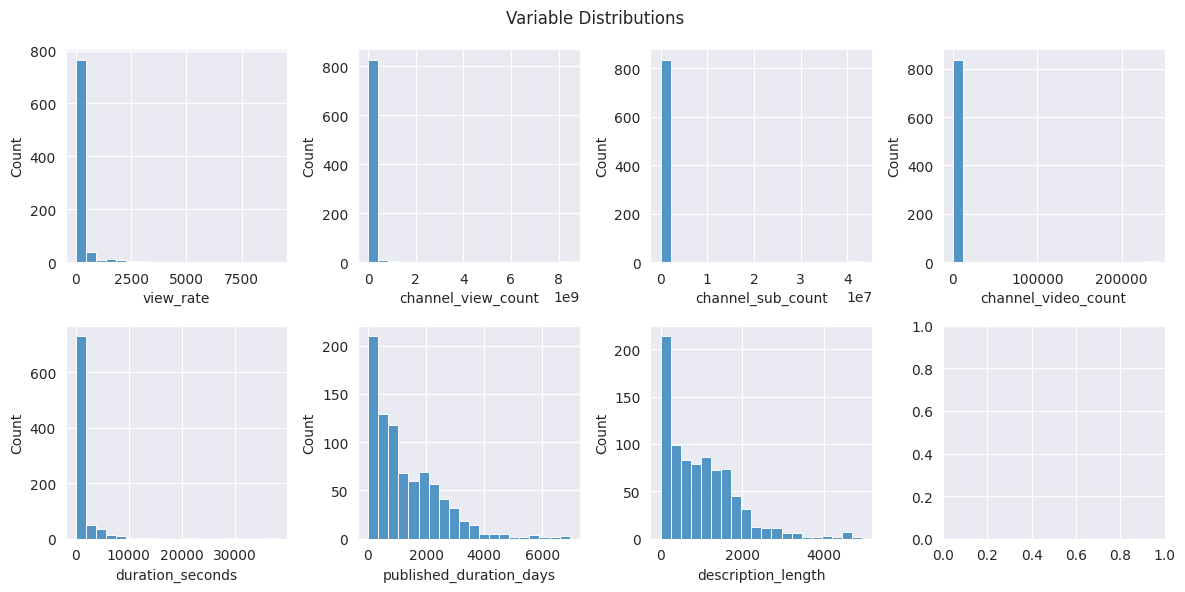

In [63]:
# check distributions for possible skew
check_distributions = ["view_rate", "channel_view_count", "channel_sub_count", "channel_video_count", "duration_seconds", "published_duration_days", "description_length"]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Variable Distributions")
i, j = 0, 0
for col in check_distributions:
    sns.histplot(ax=axes[i, j], x=video_df_filtered[col], bins=20)
    j += 1
    if j == 4:
        i += 1
        j = 0
plt.tight_layout()
plt.savefig("images/variable_distributions.png", dpi=300)

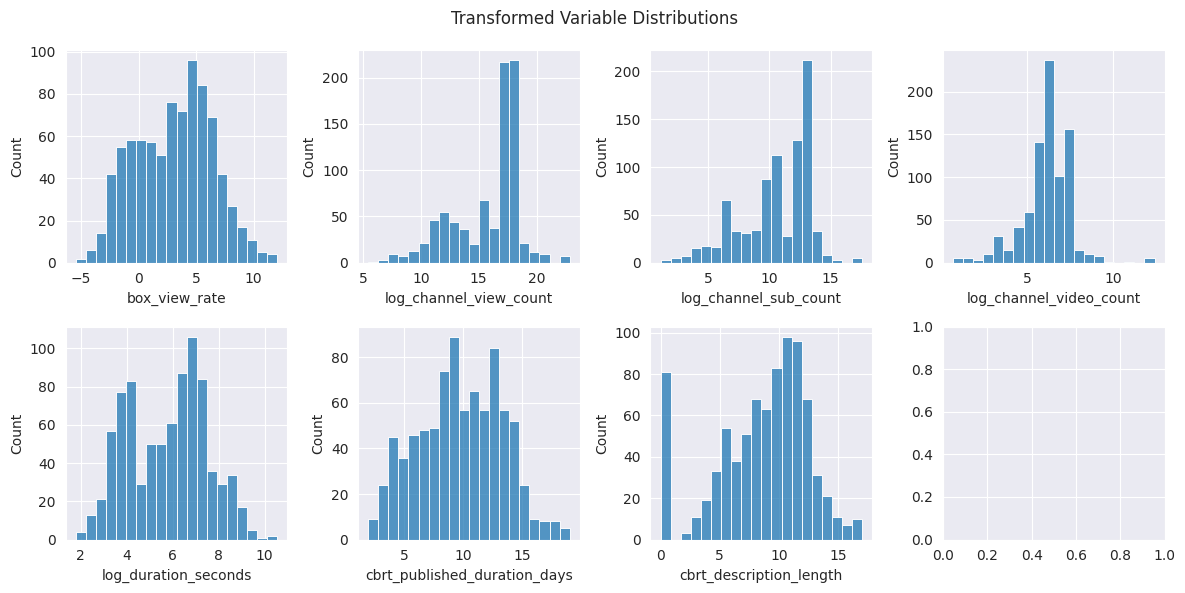

In [64]:
# transform the skewed variables to normalize the data
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Transformed Variable Distributions")
i, j = 0, 0
for col in check_distributions:
    if col == "view_rate":
        video_df_filtered[f"box_{col}"], fitted_lambda = boxcox(video_df_filtered[col])
        sns.histplot(ax=axes[i, j], x=video_df_filtered[f"box_{col}"], bins=20)
    elif col == "published_duration_days" or col == "description_length":
        video_df_filtered[f"cbrt_{col}"] = np.cbrt(video_df_filtered[col])
        sns.histplot(ax=axes[i, j], x=video_df_filtered[f"cbrt_{col}"], bins=20)
    else:
        video_df_filtered[f"log_{col}"] = np.log1p(video_df_filtered[col])
        sns.histplot(ax=axes[i, j], x=video_df_filtered[f"log_{col}"], bins=20)
        
    j += 1
    if j == 4:
        i += 1
        j = 0
plt.tight_layout()
plt.savefig("images/transformed_variable_distributions.png", dpi=300)

In [65]:
# drop old non-transformed variables
video_df_filtered.drop(columns=check_distributions, inplace=True)
video_df_filtered.head()

,video_id,title,channel_title,caption,hour_published,weekday_published,month_published,category,channel_name,is_short,...,term_years,term_youtu,term_youtube,box_view_rate,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_published_duration_days,cbrt_description_length
0,i_wWK_n83LE,Wayne Hsiung Jailed,SaLADS,0,0,6,11,People & Blogs,SaLADS,1,...,0.00000,0.0,0.244901,1.489070,11.927885,7.384610,5.752573,3.555348,8.443688,9.976612
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,Clif Grant,0,20,4,4,People & Blogs,Clif Grant,0,...,0.24063,0.0,0.063730,0.280593,12.850665,8.366603,5.389072,8.147288,10.561244,11.965177
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,Alex Punx,0,18,3,10,Nonprofits & Activism,Alex Punx,1,...,0.00000,0.0,0.000000,0.230999,14.875077,8.767329,6.741701,3.951244,11.082031,13.871269
3,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,Edmonton Vegan Outreach,0,19,0,11,Nonprofits & Activism,Edmonton Vegan Outreach,1,...,0.00000,0.0,0.000000,-1.431301,10.890628,6.786717,4.867534,4.955827,11.901979,5.325074
4,OHi9VF_0CFM,Difficulties with Non-Vegan Friends & Family (...,Earthling Ed,1,20,2,10,Nonprofits & Activism,Earthling Ed,0,...,0.00000,0.0,0.000000,4.874256,17.917472,13.030250,5.940171,6.678342,14.124736,6.431228


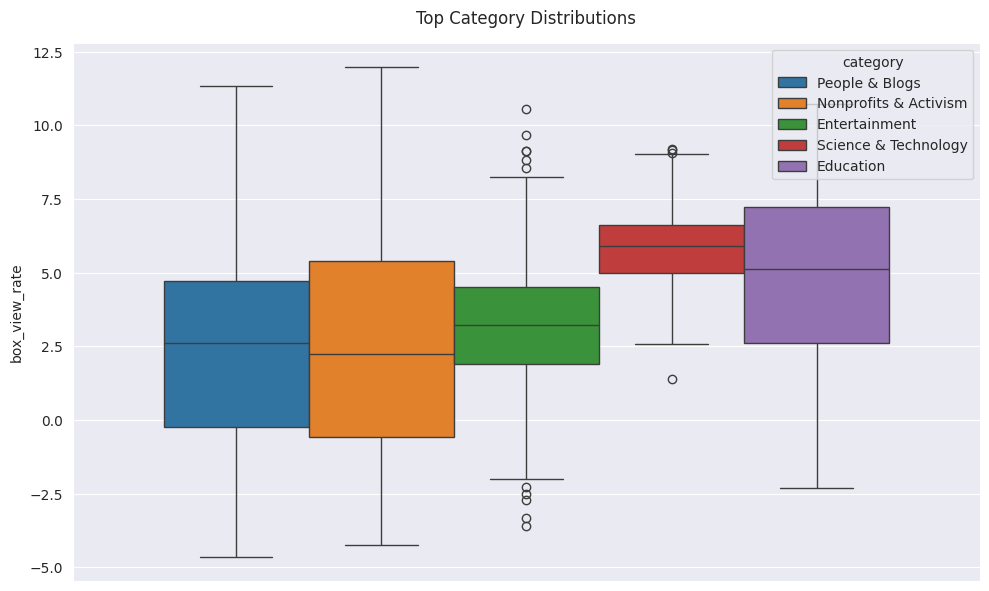

In [66]:
# visualize top category distributions
plt.subplots(figsize=(10, 6))
sns.boxplot(data=video_df_filtered, y="box_view_rate", hue=video_df_filtered[video_df_filtered["category"].isin(category_counts.head().index)]["category"])
plt.title("Top Category Distributions", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/category_distributions.png", dpi=300)

In [67]:
# check Entertainent high outliers
video_df_filtered[video_df_filtered["category"] == "Entertainment"].sort_values("box_view_rate", ascending=False).head()[["video_id", "title", "channel_title", "category"]]

,video_id,title,channel_title,category
758,AiEBL_K77ZI,Vegan RAGES At Fresh Chicken Nugget Video,David Ramms,Entertainment
787,QHxeTLRoOVw,Charlie Kirk Deleted This Debate With a Vegan,David Ramms,Entertainment
49,yJDlIR344bQ,This Isn't Even My Final Form - Dieting and Ma...,Vegan Gains,Entertainment
383,jkIrGekVIog,"Back and Biceps, Getting Shredded - Final Form...",Vegan Gains,Entertainment
73,4WTumsJR1DE,Vegan RAGES At Piers Morgan By Playing Bingo (...,David Ramms,Entertainment


In [68]:
# check Entertainent low outliers
video_df_filtered[video_df_filtered["category"] == "Entertainment"].sort_values("box_view_rate", ascending=False).tail()[["video_id", "title", "channel_title", "category"]]

,video_id,title,channel_title,category
170,Mi4aocyeJK4,Effective vegan outreach tips,The Vreedom! Quest,Entertainment
100,iJmkHHHjK7Q,Wayne Hsiung On How To Be An Effective Activist!,UNCHAINEDTV,Entertainment
162,eYU5FwNxgtc,Animal Rights Activist Wayne Hsiung Jailed; Yu...,The Bitter Pill,Entertainment
484,aZDzcnn-wHo,Vegan Outreach - Daniel Lewis sharing snacks w...,VEGAN CHURCH SERVICE,Entertainment
280,1a9HyJVPLiM,Vegan Outreach- Why I went vegetarian and then...,VEGAN CHURCH SERVICE,Entertainment


In [69]:
# check Science & Technology high outliers
video_df_filtered[video_df_filtered["category"] == "Science & Technology"].sort_values("box_view_rate", ascending=False).head()[["video_id", "title", "channel_title", "category"]]

,video_id,title,channel_title,category
647,uRGxyuTtzBY,"""Where do you get your protein?"" The Ultimate ...",Mic the Vegan,Science & Technology
285,4BaX0_5KPHQ,New Study: Oats Detox Forever Chemicals,Mic the Vegan,Science & Technology
727,ok54ZC7DLB0,Do Vegan Collagen Products Work for Skin Aging?,Mic the Vegan,Science & Technology
7,e4EnBHfeApg,Cardio vs. Weights: What Actually Helps You Li...,Mic the Vegan,Science & Technology
466,YejTv22sqeY,Seaspiracy Director Quits Veganism cuz Marshma...,Mic the Vegan,Science & Technology


In [70]:
# check Science & Technology low outliers
video_df_filtered[video_df_filtered["category"] == "Science & Technology"].sort_values("box_view_rate", ascending=False).tail()[["video_id", "title", "channel_title", "category"]]

,video_id,title,channel_title,category
594,EsvSHabokVU,"AI Told Him to Go Vegan: He Lost 80 lbs, Diabe...",Mic the Vegan,Science & Technology
517,s3o0WtISuxQ,New Frailty Study: Animal vs Plant Protein,Mic the Vegan,Science & Technology
12,yhWgTbF4ayY,What I Eat in a Day - Lockdown Edition,Mic the Vegan,Science & Technology
593,zOlN6d1CP9A,"Peter Singer: Animal Liberation, Forty Years On",Rotman Institute of Philosophy,Science & Technology
30,ad1BHES-MqI,Animal Liberation | Peter Singer and Lex Fridman,Lex Clips,Science & Technology


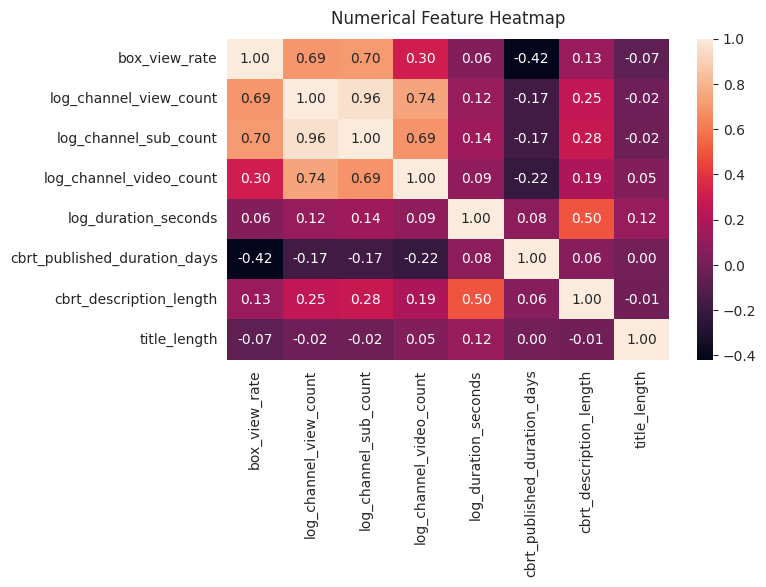

In [71]:
# visualize correlations of numerical features
numerical_features = ["box_view_rate", "log_channel_view_count", "log_channel_sub_count", "log_channel_video_count", "log_duration_seconds", "cbrt_published_duration_days", "cbrt_description_length", "title_length"]
plt.subplots(figsize=(8, 6))
sns.heatmap(video_df_filtered[numerical_features].corr(), annot=True, fmt=".2f")
plt.title("Numerical Feature Heatmap", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/numerical_heatmap.png", dpi=300)

In [72]:
# one-hot encode the categories column
categories = pd.get_dummies(video_df_filtered["category"], dtype=int, prefix="cat")
video_df_filtered = pd.concat([video_df_filtered.reset_index(drop=True), categories.reset_index(drop=True)], axis=1).drop(columns=["category", "channel_name"])
pd.set_option("display.max_columns", 50)
video_df_filtered.head()

,video_id,title,channel_title,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,tag_activism,tag_animals,tag_plant-based,tag_meat,tag_vegetarian,tag_animal liberation,tag_debate,tag_count,title_length,term_00,term_01,term_10,...,term_work,term_world,term_www,term_year,term_years,term_youtu,term_youtube,box_view_rate,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_published_duration_days,cbrt_description_length,cat_Comedy,cat_Education,cat_Entertainment,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_Other,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology
0,i_wWK_n83LE,Wayne Hsiung Jailed,SaLADS,0,0,6,11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,19,0.0,0.0,0.0,...,0.000000,0.000000,0.353566,0.0,0.00000,0.0,0.244901,1.489070,11.927885,7.384610,5.752573,3.555348,8.443688,9.976612,0,0,0,0,0,0,0,0,1,0,0
1,2w5AWKDdV9g,This Speech Will Make You Go Vegan! - Clif Gra...,Clif Grant,0,20,4,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,76,0.0,0.0,0.0,...,0.000000,0.101021,0.092007,0.0,0.24063,0.0,0.063730,0.280593,12.850665,8.366603,5.389072,8.147288,10.561244,11.965177,0,0,0,0,0,0,0,0,1,0,0
2,iVXsjWxaTFQ,Animal Liberation Front (ALF) –Raid Interfauna...,Alex Punx,0,18,3,10,1,0,0,0,0,0,0,0,0,0,0,1,0,8,53,0.0,0.0,0.0,...,0.000000,0.000000,0.066827,0.0,0.00000,0.0,0.000000,0.230999,14.875077,8.767329,6.741701,3.951244,11.082031,13.871269,0,0,0,0,0,0,1,0,0,0,0
3,yg1qRQt5z7c,Meat Eater Reacts to HEARTBREAKING Activism Fo...,Edmonton Vegan Outreach,0,19,0,11,1,1,1,1,0,0,1,0,0,1,1,0,1,36,77,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,-1.431301,10.890628,6.786717,4.867534,4.955827,11.901979,5.325074,0,0,0,0,0,0,1,0,0,0,0
4,OHi9VF_0CFM,Difficulties with Non-Vegan Friends & Family (...,Earthling Ed,1,20,2,10,0,1,1,1,0,1,1,0,0,0,1,0,0,25,66,0.0,0.0,0.0,...,0.160942,0.000000,0.000000,0.0,0.00000,0.0,0.000000,4.874256,17.917472,13.030250,5.940171,6.678342,14.124736,6.431228,0,0,0,0,0,0,1,0,0,0,0


In [73]:
# save prepared data and fitted lambda to back transform view rate
video_df_filtered.to_csv("data/videos_prepared.csv", index=False)
with open("data/fitted_lambda.pkl", "wb") as f:
    pickle.dump(fitted_lambda, f)